<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/ramp_bijector/notebooks/score_matching/NF_implicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [1]:
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@ramp_bijector

     |████████████████████████████████| 287 kB 10.1 MB/s 
     |████████████████████████████████| 126 kB 55.2 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [2]:
d=2
batch_size = 1024

In [3]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import ImplicitRampBijector

In [4]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma= 0.05)
  batch = two_moons.sample(batch_size, seed=seed) / 5 + 0.45
  return batch

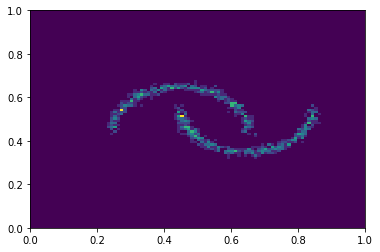

In [5]:
batch = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]);

In [6]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    # NN to get a b and c
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    a   = jax.nn.softplus(hk.Linear(output_units)(net))
    b   = jax.nn.sigmoid(hk.Linear(output_units)(net))*0.99 + 0.005
    c   = jax.nn.sigmoid(hk.Linear(output_units)(net))*0.95 + 0.02
    return ImplicitRampBijector(lambda x: x**3, a,b,c)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(0.5*jnp.ones(d),0.1*jnp.ones(d)),
            bijector=chain)
        
      return nvp

In [7]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))

In [8]:
rng_seq = hk.PRNGSequence(12)
params = model_NF.init(next(rng_seq), jnp.zeros([1,d]))

In [9]:
# TO DO
@jax.jit
def loss_fn(params, batch):
  log_prob = model_NF.apply(params, batch)
  return -jnp.mean(log_prob)

In [10]:
@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [11]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [12]:
losses = []
master_seed = hk.PRNGSequence(0)

In [16]:
for step in tqdm(range(100)):
    batch = get_batch(next(master_seed))
    l, params, opt_state = update(params, opt_state, batch)
    losses.append(l)

100%|██████████| 100/100 [00:00<00:00, 129.86it/s]


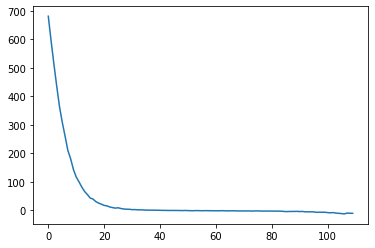

In [17]:
plot(losses)

In [ ]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0,1),
                           jnp.linspace(0,1)),-1)

imshow(model_NF.apply(params, x.reshape(-1,2)).reshape([50,50]))